### Working of ARIMA model
#### Data Mining Project, done by Waleed Saeed and Yahya Qureshi

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

In [60]:
file_path = 'Data.csv'
data = pd.read_csv(file_path)

In [61]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Standardizing the 'cycle' and 'trend' columns
data[['cycle', 'trend']] = scaler.fit_transform(data[['cycle', 'trend']])

# Display the first few rows to verify the standardization
data.head()

,id,date,Unnamed: 0,year,month,day,cycle,trend
0,0,2013-01-20,0,2013,1,20,-1.498840,-1.712394
1,1,2013-01-21,1,2013,1,21,-1.494736,-1.710988
2,2,2013-01-22,2,2013,1,22,-1.491999,-1.709583
3,3,2013-01-23,3,2013,1,23,-1.487895,-1.709583
4,4,2013-01-24,4,2013,1,24,-1.483790,-1.708177


In [62]:
# Function to perform ADF test
def perform_adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

# Perform ADF test on the 'cycle' and 'trend' columns
print("ADF Test for 'cycle':")
perform_adf_test(data['cycle'])

print("\nADF Test for 'trend':")
perform_adf_test(data['trend'])

ADF Test for 'cycle':
ADF Statistic: -1.4351614591698243
p-value: 0.5653080782145381
The series is not stationary.

ADF Test for 'trend':
ADF Statistic: -0.45148484159433394
p-value: 0.9011412968241215
The series is not stationary.


In [63]:
# Applying first order differencing to the 'cycle' and 'trend' columns
data['cycle_diff'] = data['cycle'].diff().dropna()
data['trend_diff'] = data['trend'].diff().dropna()

# Drop the initial NaN values that result from differencing
data.dropna(inplace=True)

# Display the first few rows to verify the changes
data.head()

,id,date,Unnamed: 0,year,month,day,cycle,trend,cycle_diff,trend_diff
1,1,2013-01-21,1,2013,1,21,-1.494736,-1.710988,0.004105,0.001406
2,2,2013-01-22,2,2013,1,22,-1.491999,-1.709583,0.002736,0.001406
3,3,2013-01-23,3,2013,1,23,-1.487895,-1.709583,0.004105,0.000000
4,4,2013-01-24,4,2013,1,24,-1.483790,-1.708177,0.004105,0.001406
5,5,2013-01-25,5,2013,1,25,-1.479685,-1.706772,0.004105,0.001406


In [64]:
# Let's first re-check if the differenced series are stationary using the ADF test.
print("ADF Test for 'cycle_diff':")
perform_adf_test(data['cycle_diff'])

print("\nADF Test for 'trend_diff':")
perform_adf_test(data['trend_diff'])

ADF Test for 'cycle_diff':
ADF Statistic: -4.307904224991496
p-value: 0.00043041852804289214
The series is stationary.

ADF Test for 'trend_diff':
ADF Statistic: -0.9735455786225432
p-value: 0.7627902639291348
The series is not stationary.


In [65]:
# Applying second order differencing to the 'trend_diff' column
data['trend_diff2'] = data['trend_diff'].diff().dropna()

# Drop the initial NaN values that result from the second differencing
data.dropna(inplace=True)

# Perform ADF test on the second differenced 'trend_diff' column
perform_adf_test(data['trend_diff2'])

ADF Statistic: -19.970363996162057
p-value: 0.0
The series is stationary.


In [66]:
# Fit the ARIMA model for 'cycle_diff' series
arima_model_cycle = ARIMA(data['cycle_diff'], order=(1, 1, 1))
arima_result_cycle = arima_model_cycle.fit()

# Display the summary of the ARIMA model
arima_result_cycle.summary()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             cycle_diff   No. Observations:                 3656
Model:                 ARIMA(1, 1, 1)   Log Likelihood               21075.412
Date:                Thu, 16 May 2024   AIC                         -42144.824
Time:                        13:44:53   BIC                         -42126.212
Sample:                             0   HQIC                        -42138.196
                               - 3656                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3479      0.024    -14.367      0.000      -0.395      -0.300
ma.L1         -0.4639      0.020    -23.347      0.000      -0.503      -0.425
sigma2      5.736e-07   1.55e-08     36.974      0.000    5.43e-07    6.04e-07
===================================================================================
Ljung-Box (L1) (Q):                  11.13   Jarque-Bera (JB):                 9.91
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               1.10   Skew:                             0.08
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

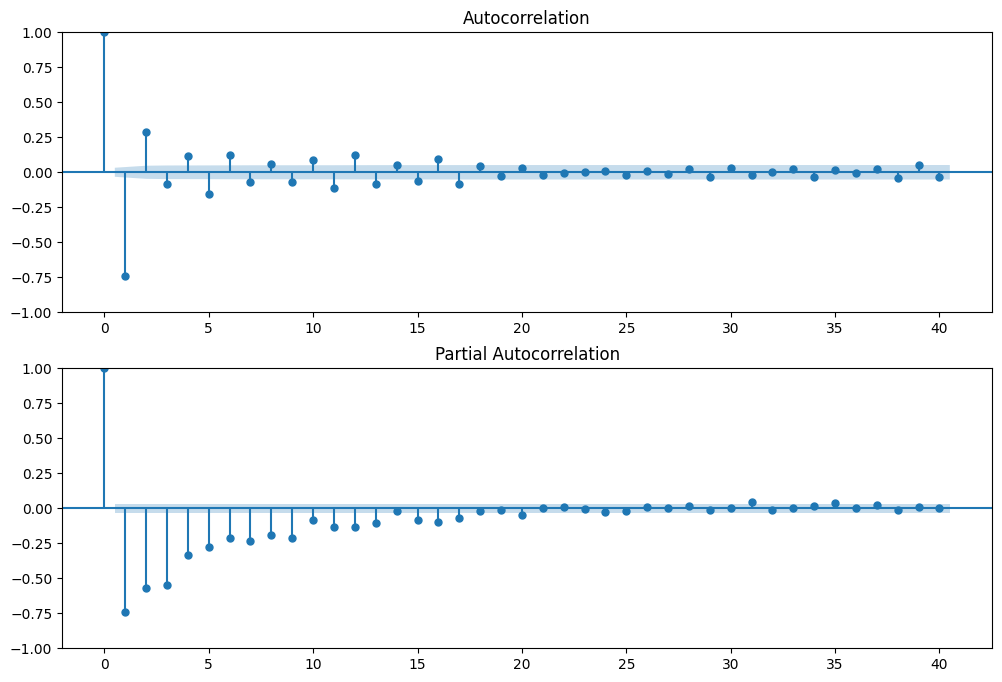

In [67]:
# Plot ACF and PACF for the 'trend_diff2' series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data['trend_diff2'], lags=40, ax=ax1)
plot_pacf(data['trend_diff2'], lags=40, ax=ax2)
plt.show()


In [68]:
# Fit the ARIMA model for 'trend_diff2' series
arima_model_trend = ARIMA(data['trend_diff2'], order=(1, 2, 1))
arima_result_trend = arima_model_trend.fit()

# Display the summary of the ARIMA model for 'trend_diff2'
arima_result_trend.summary()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            trend_diff2   No. Observations:                 3656
Model:                 ARIMA(1, 2, 1)   Log Likelihood               18845.488
Date:                Thu, 16 May 2024   AIC                         -37684.975
Time:                        13:44:57   BIC                         -37666.364
Sample:                             0   HQIC                        -37678.348
                               - 3656                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9623      0.015    -62.135      0.000      -0.993      -0.932
ma.L1         -0.9695      0.033    -29.057      0.000      -1.035      -0.904
sigma2      1.925e-06    8.9e-08     21.629      0.000    1.75e-06     2.1e-06
===================================================================================
Ljung-Box (L1) (Q):                 774.88   Jarque-Bera (JB):               398.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                            -0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
historical_data = data['cycle_diff']

# Fit ARIMA model to historical data
arima_model = ARIMA(historical_data, order=(1, 1, 1))  #
arima_result = arima_model.fit()

# Forecast future values
forecast_horizon = 12
forecast_cycle_values = arima_result.forecast(steps=forecast_horizon)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

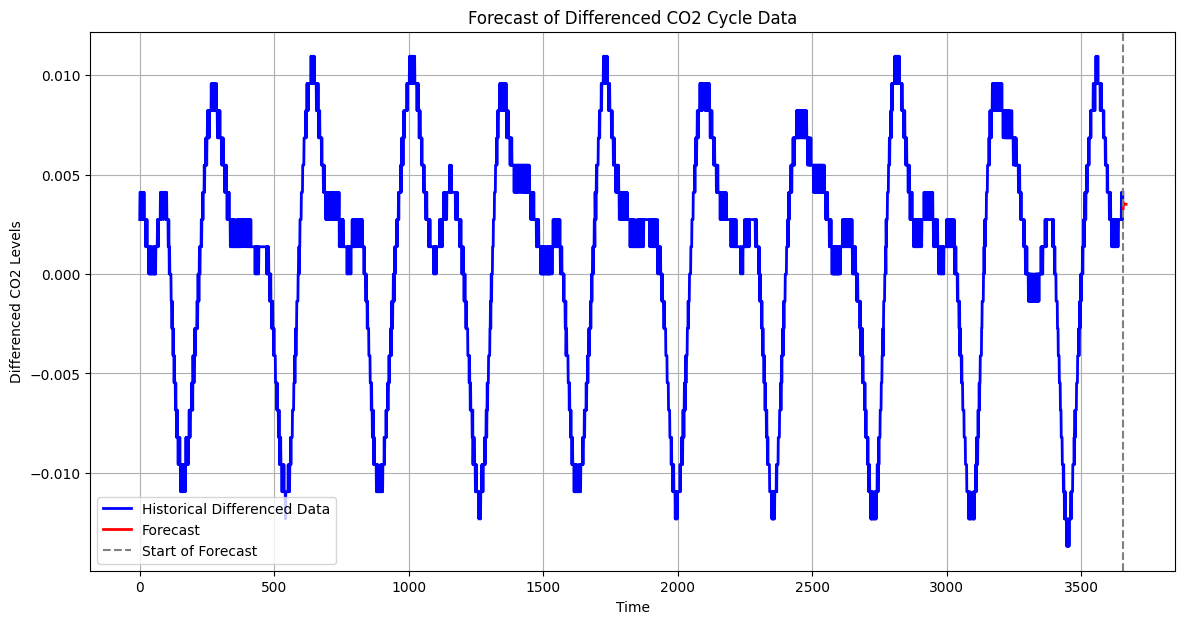

In [70]:
# Assuming you have your forecast and historical data ready
historical_data = np.array(data['cycle_diff'])  # Your actual data
forecast_data = np.array(forecast_cycle_values)         # Your forecast
forecast_index = np.arange(len(historical_data), len(historical_data) + len(forecast_data))

fig, ax = plt.subplots(figsize=(14, 7))

# Plot historical data
ax.plot(historical_data, label='Historical Differenced Data', color='blue', linewidth=2)

# Plot forecast data
ax.plot(forecast_index, forecast_data, label='Forecast', color='red', linewidth=2)

# Highlight the start of the forecast
ax.axvline(x=len(historical_data), color='gray', linestyle='--', label='Start of Forecast')

# Enhancements
ax.set_xlabel('Time')
ax.set_ylabel('Differenced CO2 Levels')
ax.set_title('Forecast of Differenced CO2 Cycle Data')
ax.grid(True)
ax.legend()

plt.show()

In [71]:
# Define the initial parameters
test_length = 365  # Assuming daily data and wanting a year for testing
num_folds = 3  # Define the number of folds

# Ensure data_series is the time series you want to forecast
data_series = data['cycle_diff']  # Ensure this is your series data

# Total length of data must support the number of folds times the test length
if len(data_series) < test_length * num_folds:
    raise ValueError("Not enough data for the number of folds and test length specified.")

# Initialize list to keep track of errors for each fold
errors = []

for i in range(num_folds):
    # Set the split points for training and testing data
    train_end = len(data_series) - (num_folds - i) * test_length
    test_end = train_end + test_length

    # Split the data into training and testing
    train_data = data_series[:train_end]
    test_data = data_series[train_end:test_end]

    # Fit the ARIMA model
    model = ARIMA(train_data, order=(1, 1, 1))
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=len(test_data))

    # Calculate and collect the error
    error = mean_squared_error(test_data, forecast)
    errors.append(error)

# Calculate the average error across all folds
average_error = np.mean(errors)
print('Average MSE:', average_error)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Average MSE: 4.072490794647664e-05


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


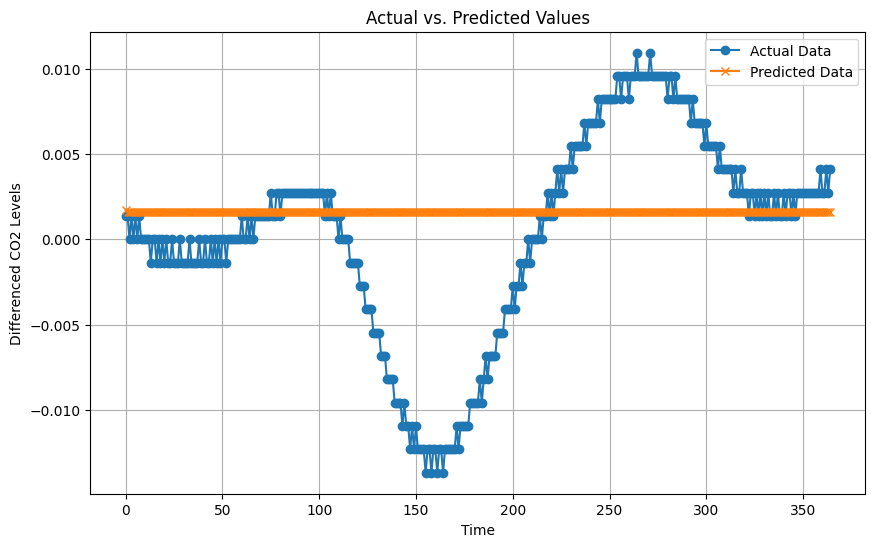

In [72]:
# Convert the data to numpy arrays if not already
test_data_array = np.array(test_data)
forecast_array = np.array(forecast)

# If the data does not have an explicit index, create a simple integer index
index = np.arange(len(test_data))

# Now, plot the data using these arrays and the created index
plt.figure(figsize=(10, 6))
plt.plot(index, test_data_array, label='Actual Data', marker='o')
plt.plot(index, forecast_array, label='Predicted Data', marker='x')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time')
plt.ylabel('Differenced CO2 Levels')
plt.legend()
plt.grid(True)
plt.show()


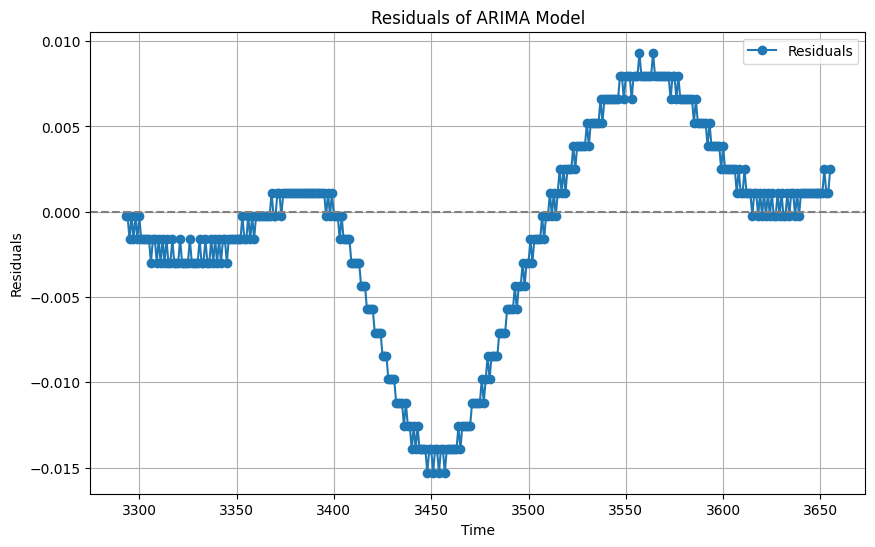

Ljung-Box test statistic: lb_stat
Ljung-Box test p-value: lb_pvalue


In [73]:
# Compute residuals
residuals = test_data - forecast

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals', marker='o')
plt.title('Residuals of ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

# Ljung-Box test
lb_value, lb_pvalue = acorr_ljungbox(residuals, lags=[10], return_df=False)
print("Ljung-Box test statistic:", lb_value)
print("Ljung-Box test p-value:", lb_pvalue)


In [74]:
# Ensure residuals are a numeric array without NaNs
residuals = np.array(residuals.dropna())  # Assuming residuals are stored in a Pandas Series

# Run Ljung-Box test safely
if len(residuals) > 10:  # Ensure there are enough data points
    lb_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print("Ljung-Box test result:\n", lb_result)
else:
    print("Not enough data points to run Ljung-Box test for 10 lags.")


Ljung-Box test result:
         lb_stat  lb_pvalue
10  3505.607048        0.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

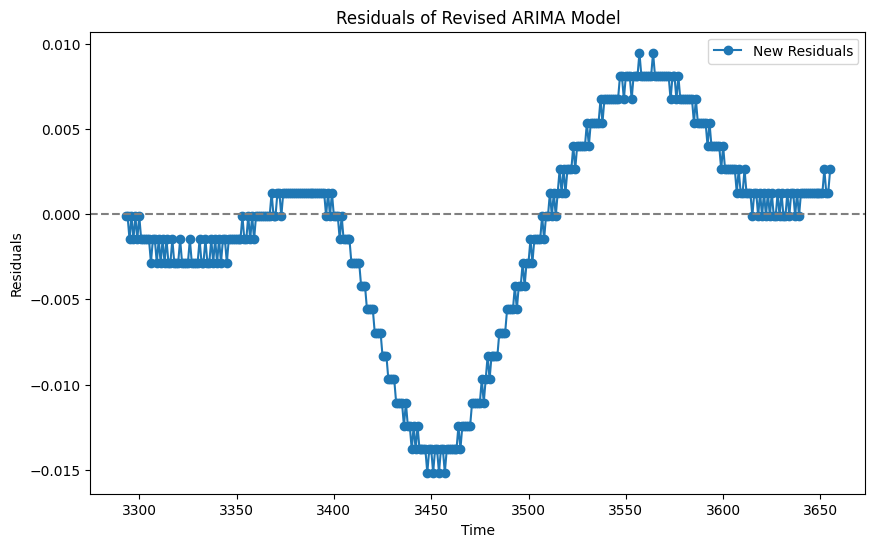

New Ljung-Box test result:
         lb_stat  lb_pvalue
10  3505.616798        0.0


In [75]:
# Example: Increasing model complexity
model = ARIMA(train_data, order=(2, 1, 2))  # Adjust 'order' based on diagnostic outcomes
model_fit = model.fit()

# Forecast, evaluate, and diagnose the new model as done previously
forecast = model_fit.forecast(steps=len(test_data))
new_residuals = test_data - forecast

# Plot new residuals and re-run Ljung-Box test
plt.figure(figsize=(10, 6))
plt.plot(new_residuals, label='New Residuals', marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Residuals of Revised ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

new_lb_result = acorr_ljungbox(new_residuals.dropna(), lags=[10], return_df=True)
print("New Ljung-Box test result:\n", new_lb_result)
